In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import statsmodels.api as sm
import patsy
import sklearn.linear_model
import sklearn.ensemble
import sklearn.neural_network
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import metrics
from xgboost import XGBRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
sns.set(rc={"figure.figsize":(12, 8)})

In [4]:
adult_df = pd.read_csv('adult20.csv')

In [5]:
need_cols = ['URBRRL', 'AGEP_A', 'SEX_A', 'EDUC_A', 'ANXEV_A', 'DEPEV_A',
             'NOTCOV_A', 'ANXFREQ_A', 'ANXLEVEL_A', 'DEPFREQ_A','DEPLEVEL_A',
             'ORIENT_A', 'MARITAL_A', 'INCGRP_A', 'BMICAT_A']

In [6]:
subset_df = adult_df[need_cols]

In [7]:
subset_df.columns

Index(['URBRRL', 'AGEP_A', 'SEX_A', 'EDUC_A', 'ANXEV_A', 'DEPEV_A', 'NOTCOV_A',
       'ANXFREQ_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPLEVEL_A', 'ORIENT_A',
       'MARITAL_A', 'INCGRP_A', 'BMICAT_A'],
      dtype='object')

In [8]:
subset_df.columns = ['urbanrural', 'age', 'sex', 'edu', 'anx_ever', 'dep_ever', 
                    'inscov', 'anx_freq', 'anx_level', 'dep_freq', 'dep_level', 
                    'orient', 'marital', 'income', 'bmi']

In [9]:
column_map = dict(zip(subset_df.columns, need_cols))

In [10]:
subset_df = subset_df.replace({"anx_freq": {5: 0}, "dep_freq": {5: 0}})

In [11]:
subset_df.isna().any()


urbanrural    False
age           False
sex           False
edu           False
anx_ever      False
dep_ever      False
inscov        False
anx_freq      False
anx_level      True
dep_freq      False
dep_level      True
orient        False
marital       False
income        False
bmi           False
dtype: bool

In [12]:
subset_df.loc[:, 'anx_level'] = subset_df.loc[:, 'anx_level'].apply(lambda x : 0 if math.isnan(x) else x)

In [13]:
subset_df.loc[:, 'dep_level'] = subset_df.loc[:, 'dep_level'].apply(lambda x : 0 if math.isnan(x) else x)

In [14]:
subset_df['anx_level'].value_counts()

1.0    11069
0.0     9676
3.0     8304
2.0     2380
9.0       83
7.0       51
8.0        5
Name: anx_level, dtype: int64

We will remove value 7, 8, 9 as it reprents 'Refused', 'Not Ascertained', 'Don't Know' which does not account to the problem we are trying to solve.

In [15]:
subset_df = subset_df[(subset_df['anx_level'] < 7.0) & (subset_df['dep_level'] < 7.0)]
subset_df = subset_df[(subset_df['anx_freq'] < 7.0) & (subset_df['dep_freq'] < 7.0)]
# less than 1% of the sample is removed.

In [16]:
column_map

{'urbanrural': 'URBRRL',
 'age': 'AGEP_A',
 'sex': 'SEX_A',
 'edu': 'EDUC_A',
 'anx_ever': 'ANXEV_A',
 'dep_ever': 'DEPEV_A',
 'inscov': 'NOTCOV_A',
 'anx_freq': 'ANXFREQ_A',
 'anx_level': 'ANXLEVEL_A',
 'dep_freq': 'DEPFREQ_A',
 'dep_level': 'DEPLEVEL_A',
 'orient': 'ORIENT_A',
 'marital': 'MARITAL_A',
 'income': 'INCGRP_A',
 'bmi': 'BMICAT_A'}

In [17]:
subset_df = subset_df[(subset_df['sex'] <= 2) & (subset_df['edu'] <= 11) & 
          (subset_df['age'] <= 85) & (subset_df['anx_ever'] <= 2) & (subset_df['dep_ever'] <= 2) & 
          (subset_df['inscov'] <= 2) & (subset_df['orient'] <= 4) & (subset_df['marital'] <= 3) &
          (subset_df['bmi'] <= 4)]

In [18]:
def map_edu(x):
    if x in {0, 1, 2, 3, 4, 5}:
        return 1
    elif x in {6, 7, 8}:
        return 2
    return 3

In [19]:
subset_df['edu'] = subset_df['edu'].apply(map_edu)

In [20]:
subset_df['anx_ever'] = subset_df['anx_ever'].apply(lambda x : 0 if (x == 2) else x)

In [21]:
subset_df['dep_ever'] = subset_df['dep_ever'].apply(lambda x : 0 if (x == 2) else x)

# Creating the score column
**Score = anx_level x anx_freq + deq_level x deq_freq**

In [22]:
def mh_score(row):
    return row['anx_level'] * row['anx_freq'] + row['dep_level'] * row['dep_freq']

In [23]:
subset_df['score'] = subset_df.apply(mh_score, axis=1)

In [24]:
score_col = subset_df['score'] 

Text(0.5, 1.0, 'Frequency Distribution of Mental Health Score')

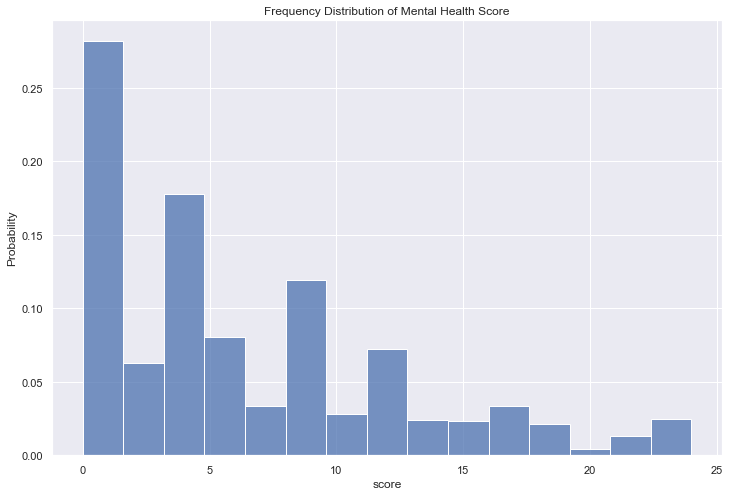

In [25]:
sns.histplot(data=subset_df, x='score', stat="probability", bins=15)
plt.title("Frequency Distribution of Mental Health Score")

In [26]:
# create new column using standard scaler
subset_df['norm_score'] = sklearn.preprocessing.StandardScaler().fit_transform(subset_df['score'].to_numpy().reshape(-1,1))

Text(0.5, 1.0, 'Frequency Distribution of Normalized Mental Health Score')

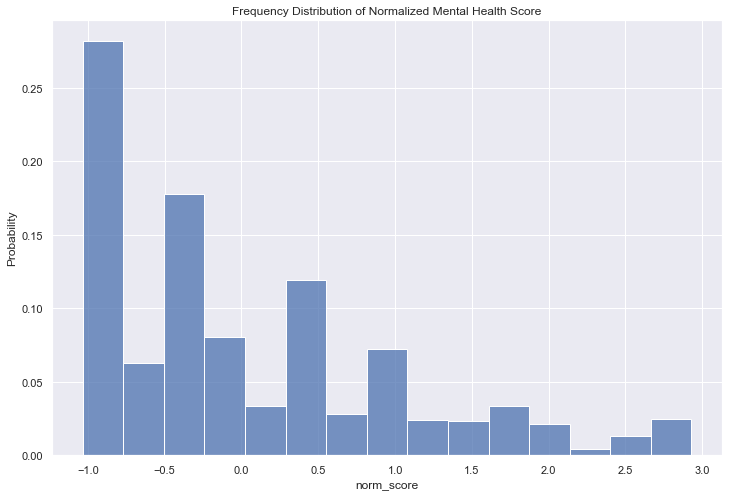

In [27]:
sns.histplot(data=subset_df, x='norm_score', stat="probability", bins=15)
plt.title("Frequency Distribution of Normalized Mental Health Score")

In [28]:
subset_df['mh_ever'] = subset_df['score'].apply(lambda x : x > 0)

Text(0.5, 1.0, 'Ever Had Mental Health Issues')

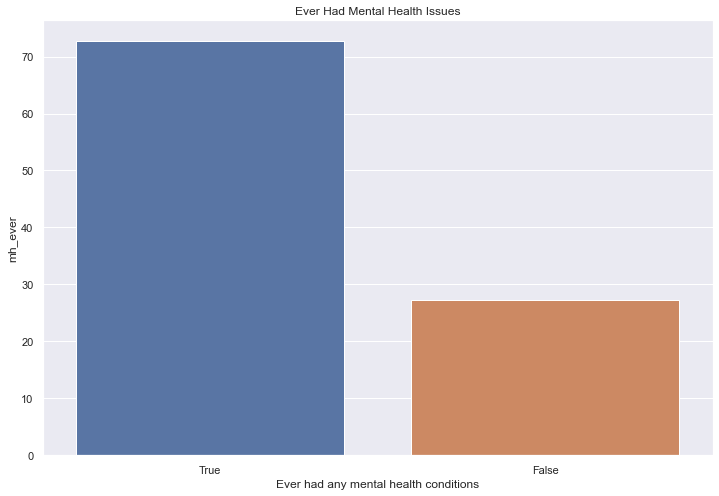

In [29]:
sns.barplot(x="mh_ever", y="mh_ever", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100, order=[True, False])
plt.xlabel('Ever had any mental health conditions')
plt.title('Ever Had Mental Health Issues')

# Data Analysis & Results
# EDA

In [30]:
subset_df.columns

Index(['urbanrural', 'age', 'sex', 'edu', 'anx_ever', 'dep_ever', 'inscov',
       'anx_freq', 'anx_level', 'dep_freq', 'dep_level', 'orient', 'marital',
       'income', 'bmi', 'score', 'norm_score', 'mh_ever'],
      dtype='object')

In [31]:
subset_df.head()

,urbanrural,age,sex,edu,anx_ever,dep_ever,inscov,anx_freq,anx_level,dep_freq,dep_level,orient,marital,income,bmi,score,norm_score,mh_ever
0,3,85,1,1,0,0,2,0,0.0,0,0.0,2,1,5,2,0.0,-1.034039,False
1,3,39,1,1,0,0,2,4,1.0,0,0.0,2,3,4,4,4.0,-0.373319,True
2,3,42,1,1,0,0,2,0,0.0,0,0.0,2,3,4,2,0.0,-1.034039,False
3,3,32,1,2,0,0,2,3,1.0,0,0.0,2,2,3,2,3.0,-0.538499,True
4,3,85,2,1,0,1,2,0,0.0,2,1.0,2,3,1,3,2.0,-0.703679,True


# Depression Score

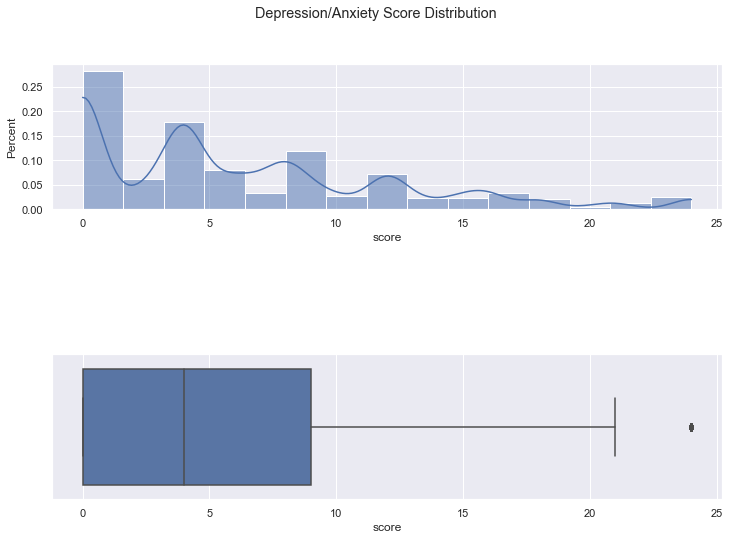

In [32]:
fig, axes = plt.subplots(2, 1)
fig.subplots_adjust(hspace=1, wspace=1)
sns.histplot(data=subset_df, x='score', bins=15, kde=True, ax = axes[0], stat="probability").set_ylabel('Percent')
plt.suptitle('Depression/Anxiety Score Distribution')
sns.boxplot(data=subset_df, x='score', ax = axes[1])
fig.show()

**Distribution is severely right-skewed, which means majority of samples in the dataset has no mental health issues**

In [33]:
def get_outliers(col):
    IQR = col.quantile(q=0.75) - col.quantile(q=0.25)
    return col[np.abs(col - col.mean()) > 1.5 * IQR]

In [34]:
get_outliers(subset_df['score'])

13       20.0
33       24.0
42       20.0
60       24.0
73       24.0
         ... 
31508    24.0
31527    21.0
31534    24.0
31537    24.0
31558    24.0
Name: score, Length: 1228, dtype: float64

There are 1261 outliers in the 'score' column according to the 1.5*IQR rule, most of our samples are concentrated in the 0-20 range.
So, we will decide to consider any sample with > 20 score as an outlier.

# Age

Text(0.5, 1.0, 'Age Distribution')

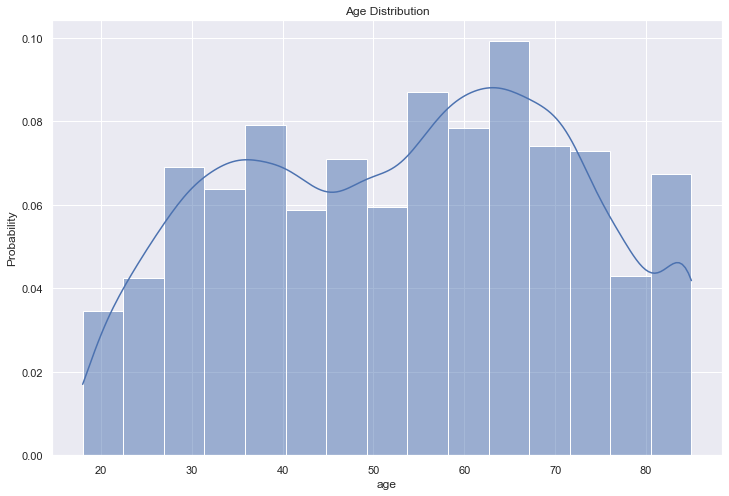

In [35]:
ax = sns.histplot(x = 'age', data = subset_df, stat="probability", bins = 15, kde=True)
ax.set_title('Age Distribution')

The Age Distrubution is approximately a uniform distribution

In [36]:
get_outliers(subset_df['age'])

Series([], Name: age, dtype: int64)

Using the  **1.5*IQR**  rule, the 'age' column does not seem to have any outliers.

# Regional Information
### Category: Urban or Rural
Code:
1. -->Large central metro 
2. -->Large fringe metro 
3. -->Medium and small metro 
4. -->Nonmetropolitan

Text(0.5, 1.0, 'Urban/Rural Breakdown')

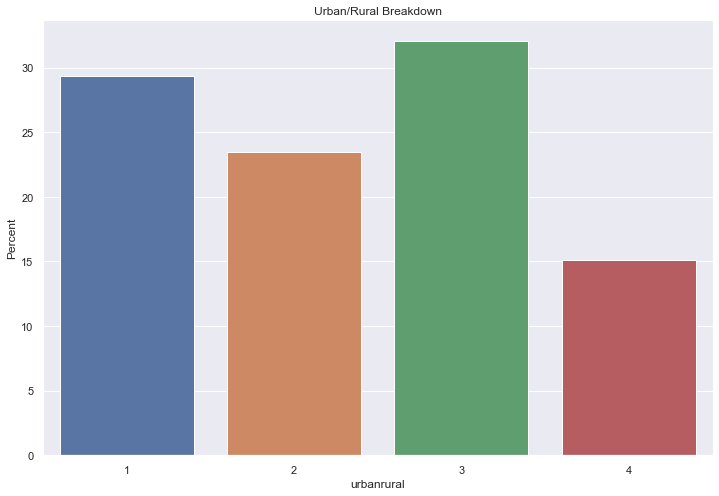

In [37]:
ax = sns.barplot(x="urbanrural", y="urbanrural", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Urban/Rural Breakdown')

Some explaination needed

# Gender
### Category: Male or Female
Code:
* 1 --> Male
* 2 --> Female

Text(0.5, 1.0, 'Gender Breakdown')

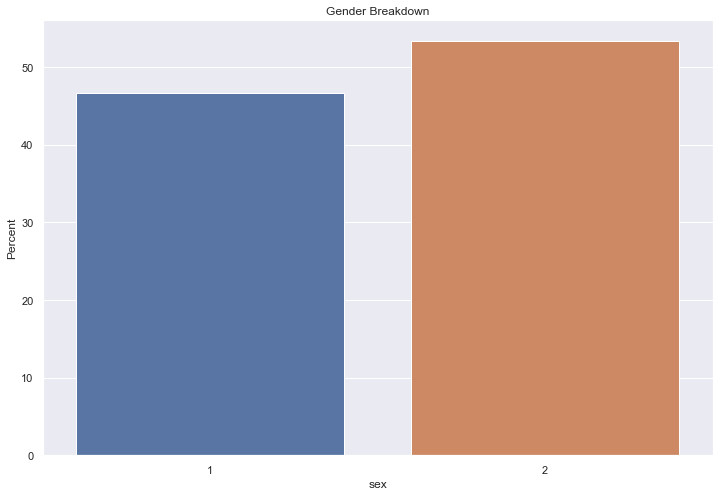

In [38]:
ax = sns.barplot(x="sex", y="sex", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Gender Breakdown')

Around 47% of the survey response is **Male**, while 53% is from **Female**

# Education Level
### Category: Below Degree, Degree, Above Degree
Code:
* 1 --> Below Degree
* 2 --> Bachelor's Degree
* 3 --> Above Degree (Masters, PhD)

Text(0.5, 1.0, 'Education Level Breakdown')

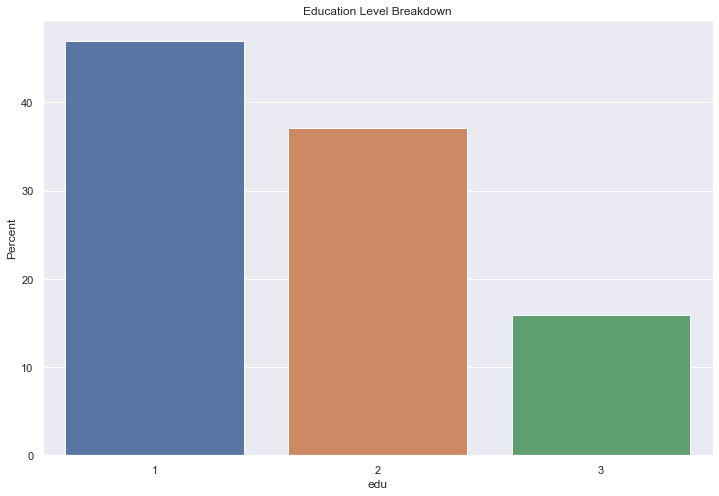

In [39]:
ax = sns.barplot(x="edu", y="edu", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Education Level Breakdown')

Explanation Needed

# Anxiety Level and Depression Level
### Category: no anxiety, A little, A lot, Somewhere in between a little and a lot
Code:
* 0 --> no anxiety
* 1 --> A little
* 2 --> A lot
* 3 --> Somewhere in between a little and a lot

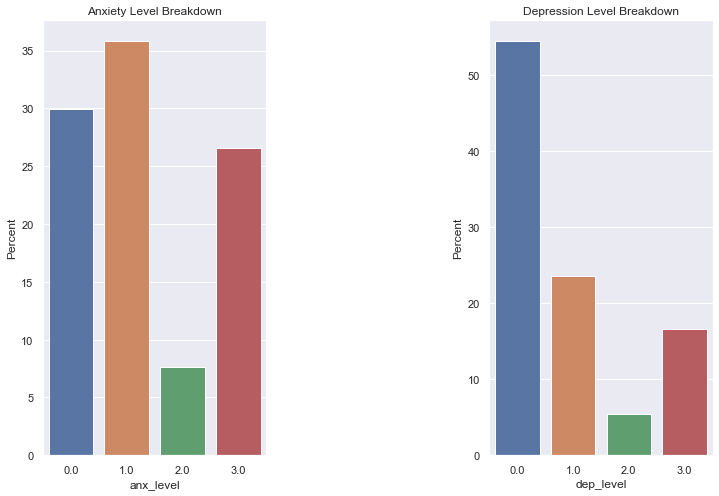

In [40]:
fig, axes =plt.subplots(1,2)
fig.subplots_adjust(hspace=1, wspace=1)
sns.barplot(x="anx_level", y="anx_level", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100, ax = axes[0]).set(ylabel="Percent")
axes[0].set_title('Anxiety Level Breakdown')
sns.barplot(x="dep_level", y="dep_level", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100, ax = axes[1]).set(ylabel="Percent")
axes[1].set_title('Depression Level Breakdown')
fig.show()

In both graphs, most people show little or no anixety/depression. However, from the Anxiety Level Breakdown plot, participants tend to be more anxious than depressesd.

# Anxiety Frequency and Depression Frequency
### Category: never, A few times a year, Monthly, Weekly, Daily
Code: 
* 0 ---> never
* 1 ---> A few times a year
* 2 ---> Monthly
* 3 ---> Weekly
* 4 ---> Daily

We will remove value 7, 8, 9 as it reprents 'Refused', 'Not Ascertained', 'Don't Know' which does not account to the problem we are trying to solve.

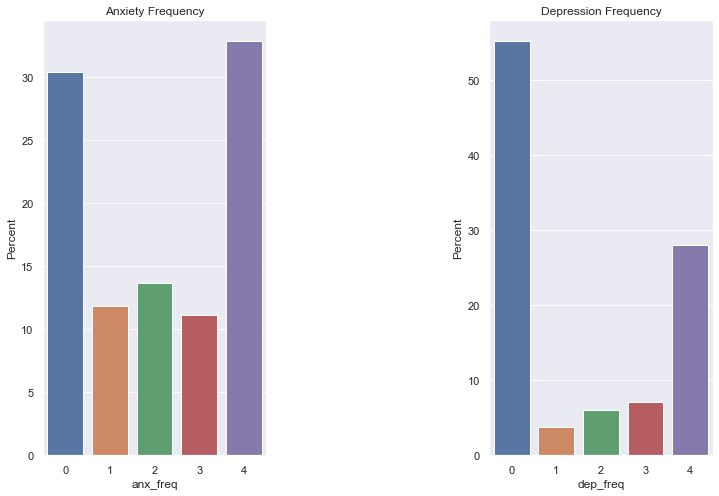

In [41]:
fig, axes =plt.subplots(1,2)
fig.subplots_adjust(hspace=1, wspace=1)

sns.barplot(x="anx_freq", y="anx_freq", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100, ax = axes[0]).set(ylabel="Percent")
axes[0].set_title('Anxiety Frequency')
sns.barplot(x="dep_freq", y="dep_freq", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100, ax = axes[1]).set(ylabel="Percent")
axes[1].set_title('Depression Frequency')
fig.show()

From the plots, we can deduce that majority of the  participants does not experience anxiety or depression. Instead, there are more people reportedly feeling anxious when compared to those who are feeling depressed. Anxiety Frequency plot is a bimodal distribution, while Depresion Frequency plot is also slight considered a bimodal distribution and slightly right-skewed.

# Insurance Coverage
### Category: Covered or Not Covered
Code:
* 1 ---> not covered
* 2 ---> covered

Text(0.5, 1.0, 'Medical Insurance Coverage')

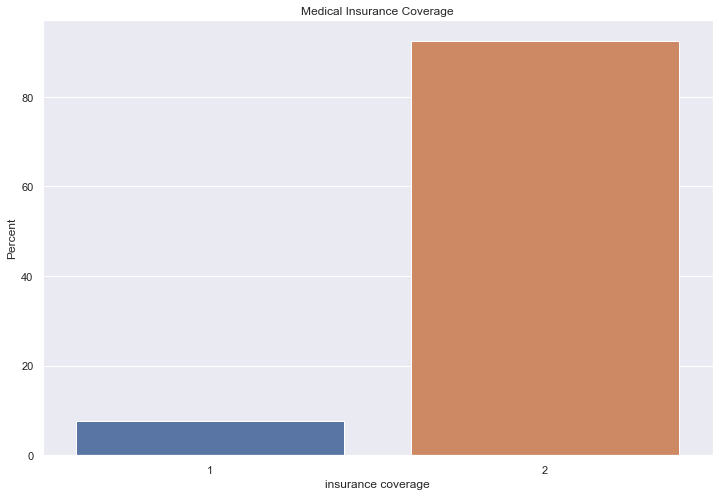

In [42]:
ax_ins = sns.barplot(x="inscov", y="inscov", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax_ins.set(ylabel="Percent", xlabel = 'insurance coverage')
ax_ins.set_title('Medical Insurance Coverage')

From the plot, it is clear that vast majority of samples have insurance covered. Thus, it might be a huge factor on why there are less samples having anxiety or depression.

# Sexual Orientation
### Cateogry: Gay/Lesbian, Straight, Bisexual, Something else
Code:
* 1 ---> Gay/Lesbian
* 2 ---> Straight
* 3 ---> Bisexual
* 4 ---> Something else

Text(0.5, 1.0, 'Sexual Orientation Breakdown')

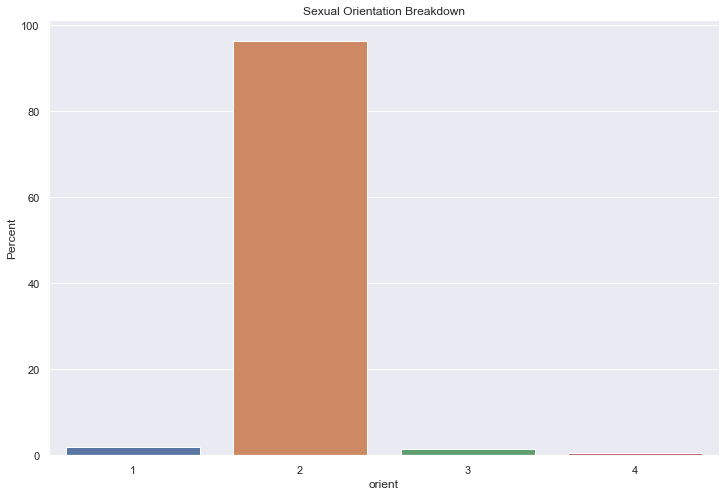

In [43]:
ax = sns.barplot(x="orient", y="orient", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax.set(ylabel="Percent")
ax.set_title('Sexual Orientation Breakdown')

From the plot, we can observe that more than 90% of samples are straight, LGBTQ individuals are higher risk of experiencing poor mental health. According to [source](https://www.mentalhealth.org.uk/statistics/mental-health-statistics-lgbtiq-people). 

# Marital
### Category: Married, Living with partner together as unmarried couple, Neither
Code:
* 1 ---> married
* 2 ---> living with partner together as unmarried couple
* 3 ---> Neither

Text(0.5, 1.0, 'Marital Status Breakdown')

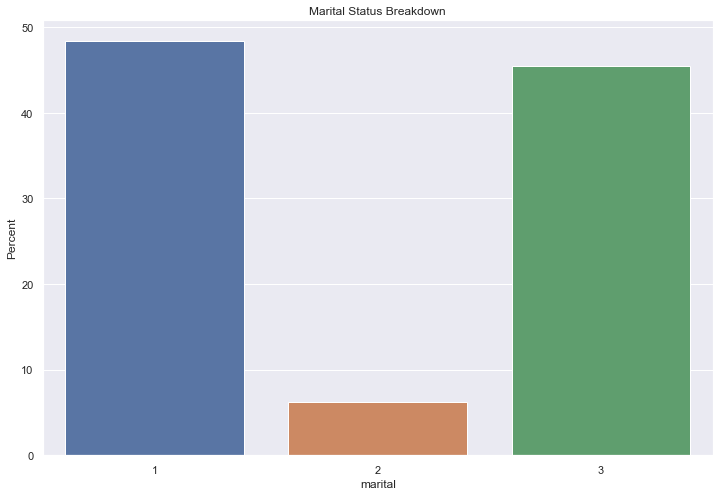

In [44]:
ax_marital = sns.barplot(x="marital", y="marital", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax_marital.set(ylabel="Percent")
ax_marital.set_title('Marital Status Breakdown')

From the plot, married category is almost equal to neither(single/divorced) category. Based on [sources](https://www.sciencedirect.com/science/article/pii/S2352827321000495), being single and being divorced were found to be risk factors for depressive symptoms and lower self-esteem.

# Income
### Discription: adult family income (grouped)
Code:
* 1 --> $0 to 34,999

* 2 --> $35,000 to 49,999

* 3 --> $50,000 to 74,999

* 4 --> $75,000 to 99,999

* 5 --> $100,000 or greater

Text(0.5, 1.0, 'Household Income Breakdown')

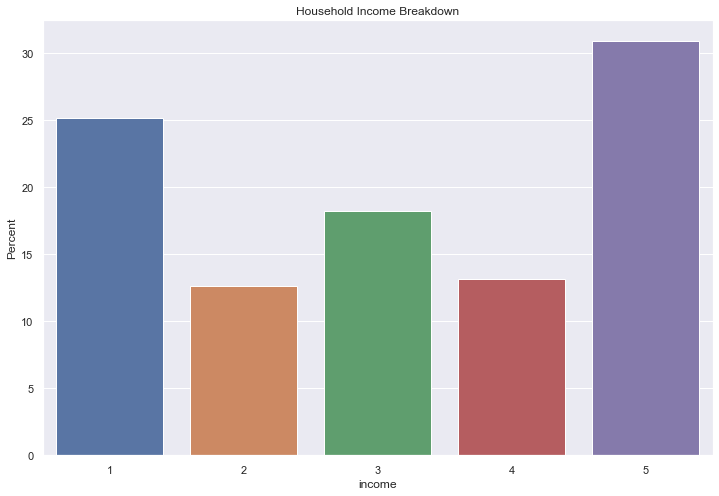

In [45]:
ax_income = sns.barplot(x="income", y="income", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax_income.set(ylabel="Percent")
ax_income.set_title('Household Income Breakdown')

Income should be a bigger factor contibuting to mental health of individuals, the plot above represents a bimodal distribution, with majority of the percentages gathered in the poorest and richest group of families. 

# BMI
### Category : Underweight, Healthy weight, Overweight, Obese
Code: 
* 1-->Underweight
* 2-->Healthy weight
* 3-->Overweight
* 4-->Obese

Text(0.5, 1.0, 'BMI Breakdown')

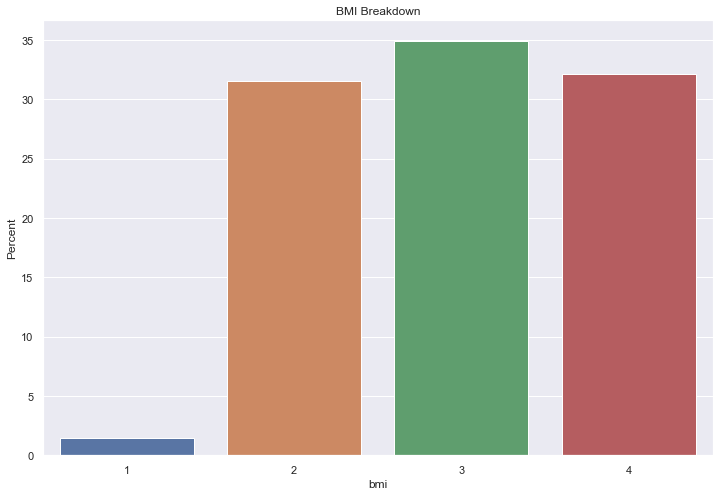

In [46]:
ax_bmi = sns.barplot(x="bmi", y="bmi", data=subset_df, estimator=lambda x: len(x) / len(subset_df) * 100)
ax_bmi.set(ylabel="Percent")
ax_bmi.set_title('BMI Breakdown')

From the graph, we can deduce that a vast majority of samples are either overweight or obese, thus indicating a major problem in the dataset we are using.
Based on the [source](https://www.goodrx.com/well-being/healthy-mind/obesity-and-mental-health), obesity is linked to mood and anxiety disorders.

# Relationship between Variables and Depression Score

### Correlation coefficient for Depression Score

In [47]:
subset_df.corr()['score']

urbanrural   -0.008825
age          -0.106128
sex           0.120152
edu           0.034687
anx_ever      0.185216
dep_ever      0.245932
inscov       -0.009074
anx_freq      0.572810
anx_level     0.775975
dep_freq      0.694935
dep_level     0.747250
orient        0.013664
marital       0.052902
income       -0.024318
bmi           0.013394
score         1.000000
norm_score    1.000000
mh_ever       0.633402
Name: score, dtype: float64

### Relationship between Income and Depression Score

In [48]:
income_score = subset_df[['income', 'score']].copy()
income_score.corr()

,income,score
income,1.000000,-0.024318
score,-0.024318,1.000000


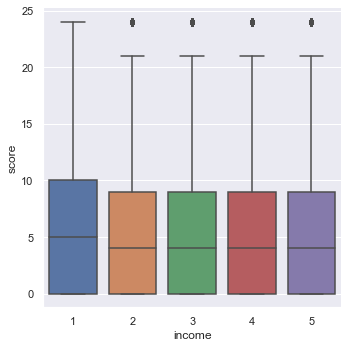

In [49]:

sns.catplot(x="income", y="score", kind="box", data=subset_df)

From the boxplot above, we can observe that lower income group tend to have higher depression score and as income increase, lesser samples have higher mental risks. Boxplot from 2 to 5 have similar meidan indicating that they have similar depression score distribution in the lower 50 percentile

### Relationship between BMI and Depression Score

In [50]:
bmi_dep = subset_df[['bmi', 'score']].copy()
bmi_dep.corr()

,bmi,score
bmi,1.000000,0.013394
score,0.013394,1.000000


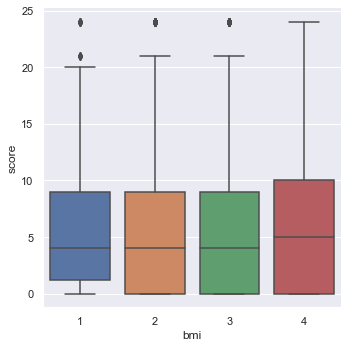

In [51]:
sns.catplot(x="bmi", y="score", kind="box", data=subset_df)

From the boxplots above, samples that are obese have have higer depression score, which is logical.

### Relationship between Gender and Depression Score

In [52]:
male_mh_score = subset_df[subset_df['sex'] == 1]['score']
female_mh_score = subset_df[subset_df['sex'] == 2]['score']

Text(0.5, 1.0, 'Depression score by gender')

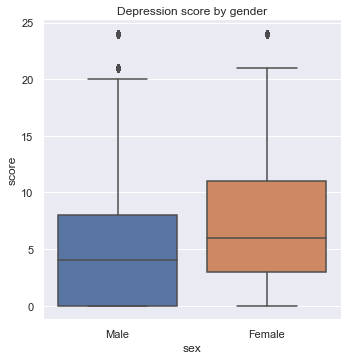

In [53]:
sns.catplot(kind='box', x='sex',y='score',data=subset_df)
ax = plt.gca()
ax.set_xticklabels(labels=['Male','Female'])
plt.title('Depression score by gender')

The above boxplot indicates that Female samples have a higher depression score compared to male samples, this is logical and somewhat accurate based on the [source](https://www.apa.org/news/press/releases/2011/08/mental-illness).
To find find out whether there is a significant difference statiscally, we will use an independent samples t test.

In [54]:
sm.stats.ttest_ind(male_mh_score, female_mh_score, alternative='smaller')

(-20.626062355180366, 3.77383251807867e-94, 29044.0)

With a p value in the order of 10e-94, we can see that the difference between male and female depression score is significant. Females generally have worse mental conditions than males.

### Relationships between Sexual Orientation and Depression Score

Since we have 4 category for Sexual Orientation (Gay/Lesbian, Straight, Bisexual, Something else). We will sort them with a new column 'LGBTQ' into binary varaible: LGBTQ or Non-LBGTQ.

In [55]:
LGBTQ_score = subset_df[subset_df['orient'] != 2]['score']
non_LGBTQ_score = subset_df[subset_df['orient'] == 2]['score']

In [56]:
# create new binary variable based on LGBTQ or straight
subset_df['lgbt'] = subset_df['orient'].apply(lambda x : 1 if x != 2 else 0)

Text(0.5, 1.0, 'Depression Score by Sexual Orientation')

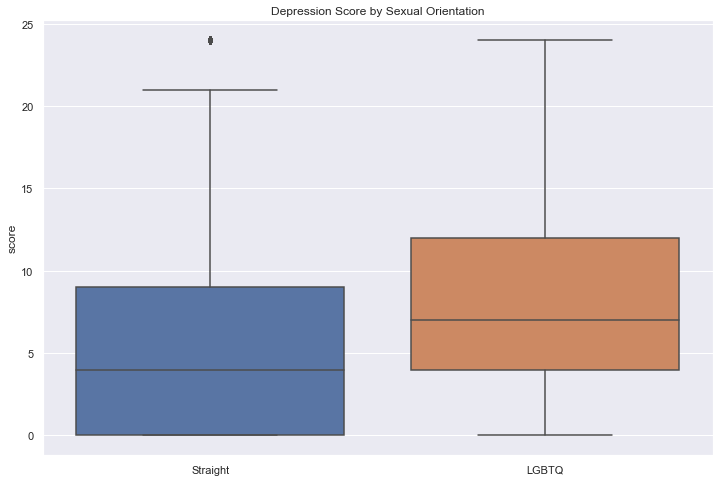

In [57]:
# A boxplot between LGBTQ and Depression Score
sns.boxplot(x='lgbt', y='score', data=subset_df)
ax = plt.gca()
ax.set_xticklabels(['Straight', 'LGBTQ'])
ax.set_xlabel('')
plt.title("Depression Score by Sexual Orientation")

From the boxplot, we can observe that the LGBTQ group have higher depression score(higher median, 25 percentile, 75 percentile) compared to Stright group
We will use independent t test again to find out the statistical difference.

In [58]:
t, p, dof = sm.stats.ttest_ind(LGBTQ_score, non_LGBTQ_score, alternative='larger')
t, p

(11.8132621150664, 1.9747205199369769e-32)

The p-value we got is very small, thus suggesting that the difference is statistically significant. The LGBTQ group does appear to have a higher mean depression score than straight group

### Relationship between BMI (body weight) and Depression Score

In the EDA section, we explored the relationship between BMI and mental health score. We hypothesized that underweight and overweight people are more likely (i.e. has higher depression score than) people with normal bodyweight.

In [59]:
underweight_scores = subset_df[subset_df['bmi'] == 1]['score']
normal_scores = subset_df[(subset_df['bmi'] == 2)]['score']
overweight_scores = subset_df[(subset_df['bmi'] == 4)| (subset_df['bmi'] == 3)]['score']

Text(0.5, 1.0, 'Depression Score by Bodyweight')

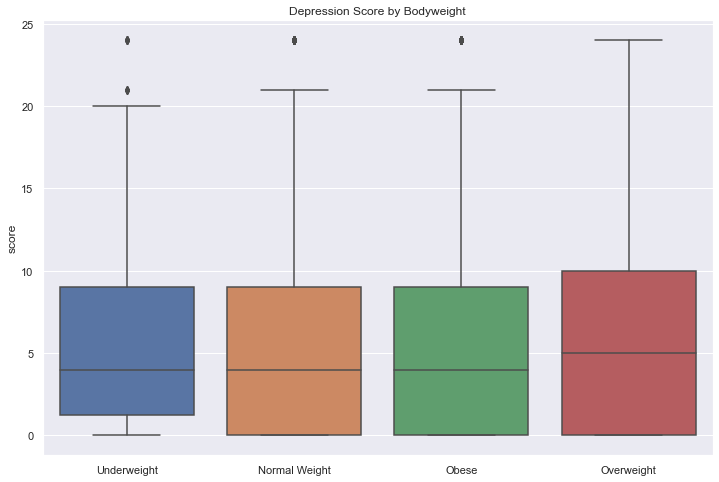

In [60]:
sns.boxplot(x='bmi', y='score', data=subset_df)
ax = plt.gca()
ax.set_xticklabels(['Underweight', 'Normal Weight', 'Obese', 'Overweight'])
ax.set_xlabel('')
plt.title("Depression Score by Bodyweight")

From the boxplots, we can point out that samples that are overweight have higher depression score(median and 75 percentile) while underweight have a higher 25 percentile compared to the rest of the boxplots. Thus, it present evidence to our hypothesis. 

### Relationship between Income and Depression Score

In [61]:
income_score = subset_df[['income', 'score']].copy()
income_score.corr()

,income,score
income,1.000000,-0.024318
score,-0.024318,1.000000


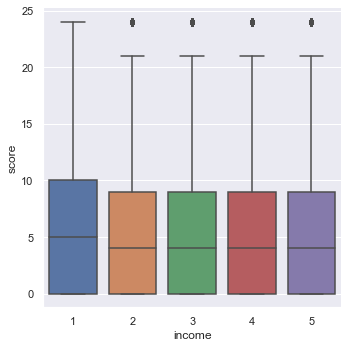

In [62]:
sns.catplot(x="income", y="score", kind="box", data=subset_df)

Our expections is that higher income will yield lower depression score. To test this, we wil use one way ANOVA to test for mean difference. **(One-way analysis of variance is a technique that can be used to compare whether two sample's means are significantly different or not.)**

In [63]:
# aggregate score by income groups, then conduct one way ANOVA
income_groups = subset_df.groupby('income').agg(list)['score']

scipy.stats.f_oneway(*income_groups)

F_onewayResult(statistic=5.035287571820111, pvalue=0.0004696961648013117)

We have a very small p-value, we have strong evidence that depression scores is not the same across all income groups. To further confirm this claim, we will conduct a pairwise Tukey's HSD test. **(Tukey's HSD test, is a single-step multiple comparison procedure and statistical test. It can be used to find means that are significantly different from each other.)**

In [64]:
print(pairwise_tukeyhsd(subset_df['score'], subset_df['income']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   -0.266 0.1906 -0.6002  0.0682  False
     1      3  -0.1709 0.5177 -0.4689  0.1271  False
     1      4  -0.3779 0.0152 -0.7077 -0.0482   True
     1      5  -0.3956  0.001 -0.6559 -0.1354   True
     2      3   0.0952    0.9 -0.2596  0.4499  False
     2      4  -0.1119    0.9 -0.4937  0.2699  False
     2      5  -0.1296 0.7855 -0.4533  0.1941  False
     3      4  -0.2071 0.4902 -0.5576  0.1435  False
     3      5  -0.2248  0.202 -0.5109  0.0614  False
     4      5  -0.0177    0.9 -0.3368  0.3014  False
----------------------------------------------------


It appears that the mean differences for (group 1 and 4) and (group 1 and 5) are statistically significant, while the others have quite similar mean depression scores.

### Relationship between Household and Depression Score

Household location is another potential predictor of mental health. Here, we expect that people who live in large urban areas are more likely to have mental health issues than people who live in rural areas due to their fast-paced lifestyles. We have 5 classes of household location. Here, we cast them into a binary variable of urban or rural.

In [65]:
subset_df['urban'] = subset_df['urbanrural'].apply(lambda x : x != 4)
rural_scores = subset_df[subset_df['urbanrural'] == 4]['score']
urban_scores = subset_df[subset_df['urbanrural'] != 4]['score']

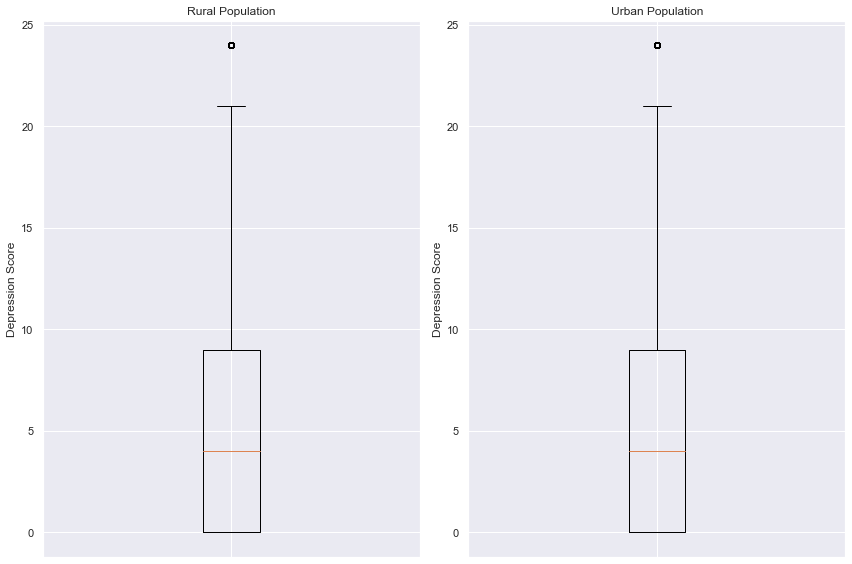

In [66]:
# display mental health score between urban and rural populations
f, a = plt.subplots(1,2)
a = a.flatten()
a[0].boxplot(rural_scores)
a[0].set_xticklabels("")
a[0].set_title('Rural Population')
a[0].set_ylabel('Depression Score')
a[1].boxplot(urban_scores)
a[1].set_xticklabels("")
a[1].set_ylabel('Depression Score')
a[1].set_title('Urban Population')
plt.tight_layout()

The boxplots above seems to contradicts our assumptions, rural groups seems to have higher dpression score.

# Machine Learning

In this section, we employ machine learning to see that if we can effectively predict mental health score using socio-demographics information. To do this, we frame both a regression and a classification task. For regression, we aim to directly predict mental health score, which is a continuous variable. For classification task, we split the dataset into score < 4.0 (median score) and score > 4.0 category, yielding a balanced classification task. We also introduce another classification task that predicts between score = 0 and score > 0, which is slightly unbalanced but is more meaningful in predicting whether people has any mental health condition than using median threshold.

In [67]:
subset_df['score'].describe()

count    29046.000000
mean         6.260070
std          6.054101
min          0.000000
25%          0.000000
50%          4.000000
75%          9.000000
max         24.000000
Name: score, dtype: float64

### Splitting the data and target
* X = features
* Y = target

In [68]:
cols = ['age', 'income', 'inscov', 'urban', 'sex', 'edu','lgbt','bmi','marital']
X = subset_df[cols]
Y = subset_df['score']

In [69]:
print(X)

       age  income  inscov  urban  sex  edu  lgbt  bmi  marital
0       85       5       2   True    1    1     0    2        1
1       39       4       2   True    1    1     0    4        3
2       42       4       2   True    1    1     0    2        3
3       32       3       2   True    1    2     0    2        2
4       85       1       2   True    2    1     0    3        3
...    ...     ...     ...    ...  ...  ...   ...  ...      ...
31562   43       3       2  False    2    2     0    4        1
31563   59       4       2  False    1    2     0    3        1
31564   55       3       2  False    2    2     0    4        1
31565   66       1       2  False    2    1     0    4        3
31566   37       3       2  False    2    1     0    4        1

[29046 rows x 9 columns]


In [70]:
print(Y)

0         0.0
1         4.0
2         0.0
3         3.0
4         2.0
         ... 
31562    12.0
31563     8.0
31564     8.0
31565    12.0
31566    14.0
Name: score, Length: 29046, dtype: float64


### Splitting Training and Test data

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

In [72]:
print(X.shape, X_train.shape, X_test.shape)

(29046, 9) (23236, 9) (5810, 9)


### Model Training

In [73]:
from sklearn.preprocessing import StandardScaler

In [74]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)

X_test_std = scaler.transform(X_test)

In [75]:
# importing tensorflow and Keras
import tensorflow as tf 
tf.random.set_seed(100) #
from tensorflow import keras

In [77]:
# setting up the layers of Neural Network

inputs = tf.keras.Input(shape=(X.shape[1],))
x = tf.keras.layers.Dense(1024, activation='relu')(inputs)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

batch_size = 256
epochs = 50

history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'lower right')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['training data', 'validation data'], loc = 'upper right')

In [ ]:
loss, accuracy = model.evaluate(X_test_std, Y_test)
print(accuracy)
# evaluate returns the loss values and metrics values

In [ ]:
print(X_test_std.shape)
print(X_test_std[0])

In [ ]:
Y_pred = model.predict(X_test_std)

In [ ]:
print(Y_pred.shape)
print(Y_pred[0])
#  You will expect 0 or 1 , but this is not the same as machine learning

In [ ]:
print(X_test_std)

In [ ]:
print(Y_pred)

In [ ]:
my_list = [0.25, 0.56]

index_of_max_value = np.argmax(my_list)
print(my_list)
print(index_of_max_value)

#### Model Evaluation
#### Prediction on Test Data
